# Introduction

Now we will attempt to fit the weather data to whether the flight was cancelled
or delayed. We saw from the EDA analysis that logistic regressions do not fit
the data well. We will use these as a baseline and attempt to improve with
other techniques.

Techniques include 5-fold cross-validation and train-test splitting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

In [2]:
stopwatch = TimeTracker.TimeTracker()
print('Importing data')
os.chdir(r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data')
flight_data = pd.read_csv('flights_with_weather.csv')

Importing data


In [3]:
CANCEL_COLOR = 'r'; DELAY_COLOR = 'orange'
PRED = 'Predicted'; ACTUAL = 'Actual'

# Preprocessing

All the departure and arrival weather codes are 0, 1, 2, or 3, so there is no
scaling needed. We do need to include the squares of weather codes that can
be greater than 1.

In [4]:
flight_data[['DepRainSqu', 'DepSnowSqu', 'ArrRainSqu', 'ArrSnowSqu']]\
    = np.square(flight_data[['DepRain', 'DepSnow', 'ArrRain', 'ArrSnow']])

#Remove the vars and columns that are insignificant or no longer necessary.
flight_data.drop(
    ['ORIGIN', 'DEST', 'WeatherDelayLength', 'DepartureTime', 'ArrivalTime',
     'DepFog', 'ArrFog', 'DepSleet', 'ArrHail'], axis=1, inplace=True)

# Training

We now have a host of columns in place to attempt to train the data. Since the
flight data are autocorrelated among time and location, let's scramble them.

In [5]:
flight_data = flight_data.sample(frac=1, random_state=1).reset_index(drop=True)

Let's recall how many of the flights were cancelled, delayed, or neither.

In [6]:
CANCELLED = 'WeatherCancelled'
DELAYED = 'WeatherDelayed'
print('Flights cancelled:', flight_data[flight_data[CANCELLED]==1].shape[0])
print('Flights delayed:', flight_data[flight_data[DELAYED]==1].shape[0])
print('All other flights:', flight_data[
    (flight_data[CANCELLED]==0) & (flight_data[DELAYED]==0)].shape[0])

Flights cancelled: 1831
Flights delayed: 2679
All other flights: 210960


The overwhelming majority of flights were neither delayed nor cancelled. We
will have to keep this into account when attempting to train the data. Any
downsampling should probably occur only on the non-cancelled, non-delayed
flights.

In [7]:
# Columns insignificant to cancellations or delays
INSIG_CANCEL_COLS = ['DepHail']
INSIG_DELAY_COLS = ['DepSnow', 'DepSnowSqu', 'ArrSnow', 'ArrSnowSqu',
                    'ArrSleet']
MISNAMED_Y_COL_MSG = 'Check y column name. Got '

In [8]:
LOG_REG = 'logistic regression'
SVC_str = 'SVC' #We already imported the classifier as SVC
FOREST = 'Random forest'

In [9]:
'''Sample all data with positive results and a portion of negative results.'''
def sample_towards_positive(data, y_column_name, portion):
    data_0 = flight_data[data[y_column_name] == 0]
    return pd.concat([data[data[y_column_name] == 1],
                      data_0.iloc[0:data_0.shape[0]:portion]])

In [10]:
def param_sweep(data, classifier, y_column_name, sample_portion, params):
    print('\n\tRunning ' + classifier + ' for ' + y_column_name\
          + ' on every ' + str(sample_portion) + ' negative data points')
    data = sample_towards_positive(data, y_column_name, sample_portion)
    y = data[y_column_name]
    X = data.iloc[:,2:]
    if classifier == LOG_REG:
        C = params #just one parameter set
        clf = GridSearchCV(
            LogReg(class_weight='balanced', random_state=1, max_iter=10000),
            {'C': C}, scoring='roc_auc', cv=5)
    elif classifier == SVC_str:
        C, gamma = params
        clf = GridSearchCV(
            SVC(class_weight='balanced', random_state=1),
            {'C': C, 'gamma': gamma}, scoring='roc_auc', cv=5)
    elif classifier == FOREST:
        n_estimators, max_depth, max_features = params
        clf = GridSearchCV(
            RandomForestClassifier(class_weight='balanced', random_state=1),
            {'n_estimators': n_estimators, 'max_depth': max_depth,
             'max_features': max_features}, scoring='roc_auc', cv=5)
    print('\tTotal targets:', data.shape[0]) #Untrimmed data
    print('\t% of negative targets', '%.4g' % (100/(data.shape[0])\
       *(data[data[y_column_name] == 0].shape[0])))
    clf.fit(X, y)
    return clf

## Logistic regressions

Since we have already tried logistic regressions on the full dataset, we will
start there and consider them as our baseline. We vary the parameter C over
the range 0.01 to 1000. We seek the best roc_auc score over a 5-fold cross
validation, which we will do for all tests.

Because of the large data, we will downsample. Most of the results are
"negative," defined as flights that are neither delayed nor cancelled, so
we will only downsample the "negative" flights and keep all "positive" ones.

In [11]:
logistic_stopwatch = TimeTracker.TimeTracker()
print('\nLogistic Regressions')
C = np.power(10, np.arange(-2,3, dtype=float))


Logistic Regressions


In [12]:
clf = param_sweep(flight_data, LOG_REG, CANCELLED, 5, params=C)
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running logistic regression for WeatherCancelled on every 5 negative data points
	Total targets: 44559
	% of negative targets 95.89
         params  mean_test_score
0   {'C': 0.01}         0.776084
1    {'C': 0.1}         0.779645
2    {'C': 1.0}         0.780571
3   {'C': 10.0}         0.780417
4  {'C': 100.0}         0.780307


In [13]:
clf = param_sweep(flight_data, LOG_REG, DELAYED, 5, params=C)
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running logistic regression for WeatherDelayed on every 5 negative data points
	Total targets: 45238
	% of negative targets 94.08
         params  mean_test_score
0   {'C': 0.01}         0.828649
1    {'C': 0.1}         0.830626
2    {'C': 1.0}         0.830934
3   {'C': 10.0}         0.830911
4  {'C': 100.0}         0.830906


Higher C's seem to yield slightly better results, but the effect is minimal.
Let's set C=1 and rerun on the full set.

In [14]:
clf = param_sweep(flight_data, LOG_REG, CANCELLED, 1, params=[1])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running logistic regression for WeatherCancelled on every 1 negative data points
	Total targets: 215470
	% of negative targets 99.15
     params  mean_test_score
0  {'C': 1}         0.780574


In [15]:
clf = param_sweep(flight_data, LOG_REG, DELAYED, 1, params=[1])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])
print(logistic_stopwatch.getElapsedTime())


	Running logistic regression for WeatherDelayed on every 1 negative data points
	Total targets: 215470
	% of negative targets 98.76
     params  mean_test_score
0  {'C': 1}         0.831076
--- 55.4 seconds ---


With 5-fold cross-validation on the full dataset, a logistic regression with
C=10 gives a mean test roc-auc score of 0.780354 for cancellations and 0.831063
for delays.

## Random Forests

Decision trees are simple and easy to train but prone to overfitting. Random
forests can help with this problem.

As before, we will downsample the "negative" flights to start. In fact we will
do this with all classifiers.

In [16]:
forest_stopwatch = TimeTracker.TimeTracker()
print('\nRandom Forests')
n_estimators = [50, 100, 150]
max_depth = np.arange(2, 6)
max_features = ['auto', 'log2']


Random Forests


In [17]:
clf = param_sweep(flight_data, FOREST, CANCELLED, 5,
                  params=[n_estimators, max_depth, max_features])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running Random forest for WeatherCancelled on every 5 negative data points
	Total targets: 44559
	% of negative targets 95.89
                                               params  mean_test_score
0   {'max_depth': 2, 'max_features': 'auto', 'n_es...         0.764843
1   {'max_depth': 2, 'max_features': 'auto', 'n_es...         0.765313
2   {'max_depth': 2, 'max_features': 'auto', 'n_es...         0.765515
3   {'max_depth': 2, 'max_features': 'log2', 'n_es...         0.764843
4   {'max_depth': 2, 'max_features': 'log2', 'n_es...         0.765313
5   {'max_depth': 2, 'max_features': 'log2', 'n_es...         0.765515
6   {'max_depth': 3, 'max_features': 'auto', 'n_es...         0.766831
7   {'max_depth': 3, 'max_features': 'auto', 'n_es...         0.764050
8   {'max_depth': 3, 'max_features': 'auto', 'n_es...         0.764999
9   {'max_depth': 3, 'max_features': 'log2', 'n_es...         0.766831
10  {'max_depth': 3, 'max_features': 'log2', 'n_es...         0.764050
11  {'max_depth': 3,

In [18]:
clf = param_sweep(flight_data, FOREST, DELAYED, 5,
                  params=[n_estimators, max_depth, max_features])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running Random forest for WeatherDelayed on every 5 negative data points
	Total targets: 45238
	% of negative targets 94.08
                                               params  mean_test_score
0   {'max_depth': 2, 'max_features': 'auto', 'n_es...         0.826287
1   {'max_depth': 2, 'max_features': 'auto', 'n_es...         0.824969
2   {'max_depth': 2, 'max_features': 'auto', 'n_es...         0.827293
3   {'max_depth': 2, 'max_features': 'log2', 'n_es...         0.826287
4   {'max_depth': 2, 'max_features': 'log2', 'n_es...         0.824969
5   {'max_depth': 2, 'max_features': 'log2', 'n_es...         0.827293
6   {'max_depth': 3, 'max_features': 'auto', 'n_es...         0.827726
7   {'max_depth': 3, 'max_features': 'auto', 'n_es...         0.829507
8   {'max_depth': 3, 'max_features': 'auto', 'n_es...         0.828445
9   {'max_depth': 3, 'max_features': 'log2', 'n_es...         0.827726
10  {'max_depth': 3, 'max_features': 'log2', 'n_es...         0.829507
11  {'max_depth': 3, '

Extending the tree beyond two levels seems to have a negligible effect, as
does whether to use more than 50 trees or the number of parameters to use.
Let's construct a random forest over the full dataset with trees of max depth
2 and 3, using 50 trees and the default setting of the number of parameters.

In [19]:
clf = param_sweep(flight_data, FOREST, CANCELLED, 1, params=[[50], [2, 3], ['auto']])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running Random forest for WeatherCancelled on every 1 negative data points
	Total targets: 215470
	% of negative targets 99.15
                                              params  mean_test_score
0  {'max_depth': 2, 'max_features': 'auto', 'n_es...         0.763532
1  {'max_depth': 3, 'max_features': 'auto', 'n_es...         0.767325


In [20]:
clf = param_sweep(flight_data, FOREST, DELAYED, 1, params=[[50], [2, 3], ['auto']])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])
print(forest_stopwatch.getElapsedTime())


	Running Random forest for WeatherDelayed on every 1 negative data points
	Total targets: 215470
	% of negative targets 98.76
                                              params  mean_test_score
0  {'max_depth': 2, 'max_features': 'auto', 'n_es...         0.827592
1  {'max_depth': 3, 'max_features': 'auto', 'n_es...         0.828745
--- 3.22 minutes ---


With 5-fold cross-validation on the full dataset, a random forest with a
max depth of 2 gives a mean test roc-auc score of 0.763532 for cancellations
and 0.827592 for delays. These numbers are slightly worse than those of the
logistic regression.

## Support Vector Classifier

The SVC is very slow with the full data, so we will resample it. Since the
data have already been scrambled by row, we can pick every nth row. We should
get as many rows as we can that have cancelled/delayed flights.

In [21]:
svc_stopwatch = TimeTracker.TimeTracker()
print('\nSupport Vector Classifiers')
C = np.power(10, np.arange(-2,3, dtype=float))


Support Vector Classifiers


In [22]:
clf = param_sweep(
    flight_data, SVC_str, CANCELLED, 100, params=[C, ['scale', 'auto']])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running SVC for WeatherCancelled on every 100 negative data points
	Total targets: 3968
	% of negative targets 53.86
                           params  mean_test_score
0   {'C': 0.01, 'gamma': 'scale'}         0.749051
1    {'C': 0.01, 'gamma': 'auto'}         0.749108
2    {'C': 0.1, 'gamma': 'scale'}         0.751204
3     {'C': 0.1, 'gamma': 'auto'}         0.752221
4    {'C': 1.0, 'gamma': 'scale'}         0.766669
5     {'C': 1.0, 'gamma': 'auto'}         0.764055
6   {'C': 10.0, 'gamma': 'scale'}         0.764032
7    {'C': 10.0, 'gamma': 'auto'}         0.764089
8  {'C': 100.0, 'gamma': 'scale'}         0.760683
9   {'C': 100.0, 'gamma': 'auto'}         0.761253


In [23]:
clf = param_sweep(
    flight_data, SVC_str, DELAYED, 100, params=[C, ['scale', 'auto']])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running SVC for WeatherDelayed on every 100 negative data points
	Total targets: 4807
	% of negative targets 44.27
                           params  mean_test_score
0   {'C': 0.01, 'gamma': 'scale'}         0.803285
1    {'C': 0.01, 'gamma': 'auto'}         0.806161
2    {'C': 0.1, 'gamma': 'scale'}         0.812295
3     {'C': 0.1, 'gamma': 'auto'}         0.810096
4    {'C': 1.0, 'gamma': 'scale'}         0.798263
5     {'C': 1.0, 'gamma': 'auto'}         0.784588
6   {'C': 10.0, 'gamma': 'scale'}         0.783771
7    {'C': 10.0, 'gamma': 'auto'}         0.792701
8  {'C': 100.0, 'gamma': 'scale'}         0.800781
9   {'C': 100.0, 'gamma': 'auto'}         0.782437


All of these do pretty well. Let's explore what happens with much larger
downsampling of the negative data. Gamma doesn't affect things much, so
we will stick with the default of 'scale.'

In [24]:
clf = param_sweep(flight_data, SVC_str, CANCELLED, 10, params=[C, ['scale']])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running SVC for WeatherCancelled on every 10 negative data points
	Total targets: 23195
	% of negative targets 92.11
                           params  mean_test_score
0   {'C': 0.01, 'gamma': 'scale'}         0.754880
1    {'C': 0.1, 'gamma': 'scale'}         0.754797
2    {'C': 1.0, 'gamma': 'scale'}         0.759097
3   {'C': 10.0, 'gamma': 'scale'}         0.755464
4  {'C': 100.0, 'gamma': 'scale'}         0.748667


In [25]:
clf = param_sweep(flight_data, SVC_str, DELAYED, 10, params=[C, ['scale']])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])

'''With C=0.01 and sampling every 5th flight, the mean test score is 0.753519
for cancellation predictions and 0.801357 for delay predictions.'''


	Running SVC for WeatherDelayed on every 10 negative data points
	Total targets: 23959
	% of negative targets 88.82
                           params  mean_test_score
0   {'C': 0.01, 'gamma': 'scale'}         0.814059
1    {'C': 0.1, 'gamma': 'scale'}         0.796126
2    {'C': 1.0, 'gamma': 'scale'}         0.791745
3   {'C': 10.0, 'gamma': 'scale'}         0.780220
4  {'C': 100.0, 'gamma': 'scale'}         0.762042


'With C=0.01 and sampling every 5th flight, the mean test score is 0.753519\nfor cancellation predictions and 0.801357 for delay predictions.'

At this level, C has a negligible effect on cancellations and a slight
effect on delays. Let's run again with C=0.01 on both and 1 in 5 negatives.

In [26]:
clf = param_sweep(
    flight_data, SVC_str, CANCELLED, 5, params=[[0.01], ['scale']])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])


	Running SVC for WeatherCancelled on every 5 negative data points
	Total targets: 44559
	% of negative targets 95.89
                          params  mean_test_score
0  {'C': 0.01, 'gamma': 'scale'}         0.753519


In [27]:
clf = param_sweep(
    flight_data, SVC_str, DELAYED, 5, params=[[0.01], ['scale']])
clf_results = pd.DataFrame(clf.cv_results_)
print(clf_results[['params','mean_test_score']])
print(svc_stopwatch.getElapsedTime())


	Running SVC for WeatherDelayed on every 5 negative data points
	Total targets: 45238
	% of negative targets 94.08
                          params  mean_test_score
0  {'C': 0.01, 'gamma': 'scale'}         0.801357
--- 15.87 minutes ---


With C=0.01 and sampling every 5th flight, the mean test score is 0.753519
for cancellation predictions and 0.801357 for delay predictions. These are
slightly worse than the logistic regression and random forest. For the
computation time needed, SVC is probably not worth it.

# ROC Curve

All three of these classifiers have very similar mean test scores. Since the
SVC is much slower to run with no better results, we eliminate it. Logistic
regressions have explicit output parameters, while random forests do not, so
we choose the logistic regression with the parameters above.

In [16]:
LABEL_SIZE = 14
TICK_SIZE = 10

In [17]:
'''Plot curves such as the ROC curve.'''
def plot_curve(x_data, y_data, xlabel, ylabel, datalabel, linecolor):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot([0, 1], [0,1], c='k', ls='--')
    ax.plot(x_data, y_data, c=linecolor, marker='.', markersize=10,
            label=datalabel)
    ax.legend(loc='lower right', fontsize = LABEL_SIZE)
    tickRange = np.round(np.linspace(0, 1, 6), 2) #fixes some weird imprecision
    ax.set_xlabel(xlabel, fontsize=LABEL_SIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_SIZE)
    ax.set_xticks(tickRange)
    ax.set_yticks(tickRange)
    ax.set_xticklabels(tickRange, fontsize=TICK_SIZE)
    ax.set_yticklabels(tickRange, fontsize=TICK_SIZE)
    plt.show()

### Cancellations

In [18]:
y = flight_data[CANCELLED]
X = flight_data.iloc[:,2:]
X_train, X_test, y_train, y_test_canc = train_test_split(
    X, y, test_size=0.5, random_state=1)
del(X, y)

AUC score of cancellations: 0.778


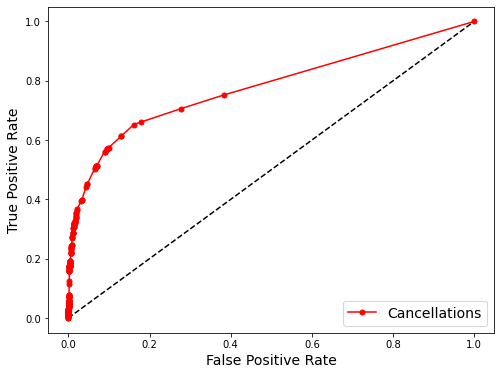

In [19]:
clf = LogReg(class_weight='balanced', random_state=1, max_iter=10000)\
    .fit(X_train, y_train)
lr_probs_cancel = clf.predict_proba(X_test)[:, 1] #only for the positives
auc_score = roc_auc_score(y_test_canc, lr_probs_cancel)
print('AUC score of cancellations: %.3f' % auc_score)
lr_cancel_fpr, lr_cancel_tpr, thresholds_cancel = roc_curve(
    y_test_canc, lr_probs_cancel)
plot_curve(lr_cancel_fpr, lr_cancel_tpr, 'False Positive Rate',
           'True Positive Rate', 'Cancellations', CANCEL_COLOR)
y_outcome_cancel = pd.DataFrame({PRED: lr_probs_cancel,
                                 ACTUAL: y_test_canc})

### Delays

In [20]:
y = flight_data[DELAYED]
X = flight_data.iloc[:,2:]
X_train, X_test, y_train, y_test_delay = train_test_split(
    X, y, test_size=0.5, random_state=1)
del(X, y)

AUC score of delays: 0.831


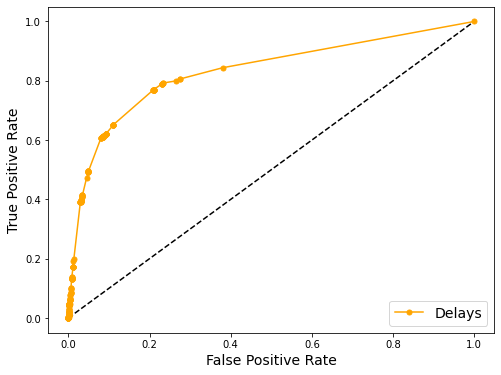

In [21]:
clf = LogReg(class_weight='balanced', random_state=1, max_iter=10000)\
    .fit(X_train, y_train)
lr_probs_delay = clf.predict_proba(X_test)[:, 1] #only for the positives
auc_score = roc_auc_score(y_test_delay, lr_probs_delay)
print('AUC score of delays: %.3f' % auc_score)
lr_delays_fpr, lr_delays_tpr, thresholds_delay = roc_curve(
    y_test_delay, lr_probs_delay)
plot_curve(lr_delays_fpr, lr_delays_tpr, 'False Positive Rate',
           'True Positive Rate', 'Delays', 'orange')
y_outcome_delays = pd.DataFrame({'Predicted': lr_probs_delay,
                          'Actual': y_test_delay})

Despite the concern about the weather data, this model seems to hold up rather
well. We got a cancellation AUC of 0.778 and a delay AUC of 0.831. More
reliable weather data would probably raise these numbers even higher.

## ROC Curve
As discussed before, only a small percentage of flights are delayed or
cancelled. This means that the overwhelming majority of our actual results are
negative. As such, negative results are much easier for our model to predict,
and the false positive rate is much easier to control than the false negative
rate.

## FPR vs. FNR
We should discuss what false positives and false negatives mean in the context
of our model, which is used to predict whether a flight will be cancelled or
delayed, not whether to make the decision to delay or cancel a flight. Ideally
the decision would be an internal one to make preparations for an upcoming
delay or cancellation. A false positive means that such preparations are made
when there is no cancellation/delay, and a false negative means that no
preparations are made ahead of time when there is a cancellation or delay.

### Delays
In an ideal world, if it could be known with perfect certainty whether a flight
would be delayed, airlines could make adjustments accordingly. They could
adjust crew schedules and send out customer notifications that a flight is
expected to be depart (or arrive) late. But if an airline does so by mistake,
they will not have their crew present, which will shift a weather-based delay
to an airline-based delay. Furthermore, they may irritate passengers who
thought they had a greater time margin of error than they actually had.

On the flip side, if passengers and crew show up thinking that the flight will
be on time but it actually isn't, there is less risk to the airline. Delays
are a normal part of flight travel, and customers are less likely to be
irritated by the airline if they don't find out about the delay until they
arrive at the airport. Furthermore, delays are rarely more than an hour, and
large airports especially have plenty for departing passengers to do as they
wait to fly. So if the evidence is not overwhelmingly in favor of predicting
that a flight will be delayed until a delay is actually announced, an airline
shouldn't do so. This means that the cost of a false negative is far less than
that of a false positive.

### Cancellations
Cancellations are rarer than delays, which is a good thing, because
cancellations disrupt travel much more severely than delays. In some cases,
including with the dataset available to us, cancellations can involve entire
airports shutting down for a day or more. If an airline could have a tool that
could preemptively avoid the expensive of bringing the plane and crew to the
gate for a flight that never happens, they could save a lot of money. But a
false positive here means not scheduling a flight that should have flown. This
is a catastrophic decision that can cost the in both the short and long run.

## Plots
We are going to focus on two specific sets of misclassifications: the
false observation rate (FOR), instances where the outcome is positive in spite
of a negative prediction, and the false positive rate (FPR), instances where we
predicted what turned out to be a negative situation as positive.

Both have costs associated with them but very different costs. The FOR is the
portion of cases that "slip through the cracks": flights that we project would
not be cancelled/delayed but turn out to be. Likewise, the FPR is the portion 
of flights that are not cancelled or delayed but we projected would be.

The FOR is problematic for the customer experience: Passengers come to the
airport, expecting to fly, but their flight is delayed or cancelled. The FPR
is problematic for the airline: The flight should have been flown and on time
but was not.

Next we need to assign a value to each. We assume for simplicity that a false
positive will induce the same problem that we attempted to avoid: A false
positive delay will cause a flight delay, and a false positive cancellation
will cause the flight to be cancelled. We do not have cost figures available
to know the relative costs of each; acquiring that data is beyond the scope
of this project. However we can still build the model as a proof of concept
with the ability to tune this ratio. Let C = cost. We assume that for both
delays, and cancellations, C(FOR) = 25 times C(FPR).

In [27]:
'''False Observation Rate = P(actual positive | predicted negative)
   False Positive Rate = P(predicted positive | actual negative)
   
   Increasing the threshold increases the FPR and decreases the FOR.'''
def FOR_FPR(y_outcome, threshold_array):
    FOR_array = []
    FPR_array = []
    for threshold in threshold_array:
        y_outcome['Pred_Thresh'] = y_outcome['Predicted']>threshold
        FPR_array.append(y_outcome[y_outcome["Actual"] == 0]['Pred_Thresh'].mean())
        FOR_array.append(y_outcome[y_outcome['Pred_Thresh'] == 0]['Actual'].mean())
    return np.array(FOR_array), np.array(FPR_array)

In [28]:
def plot_FOR_FPR(y_outcome, cancels):
    threshold_array = np.sort(np.unique(y_outcome['Predicted']))
    FOR, FPR = FOR_FPR(y_outcome, threshold_array)

    FOR_FPR_cost_ratio = [25, 25][cancels]
    costs = 100*(FPR + FOR_FPR_cost_ratio*FOR)
    min_cost_loc = np.argmin(costs)
    min_cost = np.min(costs) #y on graph

    fig, ax = plt.subplots()
    color = [DELAY_COLOR, CANCEL_COLOR][cancels]
    ax2 = ax.twinx()
    
    FPR_line = ax.plot(threshold_array, FPR, c=color, label='FPR')
    FOR_line = ax.plot(threshold_array, FOR, c=color, ls='--', label='FOR')
    cost_line = ax2.plot(threshold_array, costs, c='k', ls='-.', label='Cost')
    low_cost = ax2.plot(
        threshold_array[min_cost_loc], min_cost, c='k', marker='o',
        markersize=10, markeredgewidth=5, lw=0, fillstyle='none',
        label='Min cost', zorder=5)
    ax2.plot(2*[threshold_array[min_cost_loc]], [0, min_cost-1])
    
    plots = FPR_line + FOR_line + low_cost
    labels = [plot.get_label() for plot in plots]
    ax.legend(plots, labels, loc='upper center')
    
    ax.set_xlabel('Threshold', fontsize=LABEL_SIZE)
    ax.set_ylabel('Value', fontsize=LABEL_SIZE)
    ax2.set_ylabel('Relative cost', fontsize=LABEL_SIZE)
    return FOR, FPR, costs

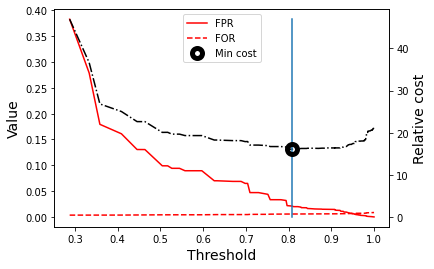

In [24]:
cancel_FOR, cancel_FPR, cancel_costs = plot_FOR_FPR(y_outcome_cancel, cancels=True)

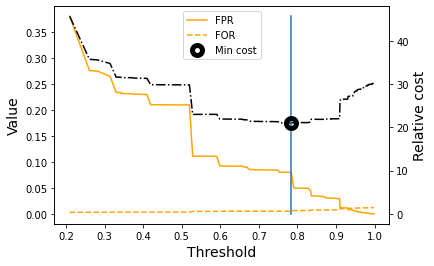

In [25]:
delay_FOR, delay_FPR, delay_costs = plot_FOR_FPR(y_outcome_delays, cancels=False)

In [26]:
print("Total runtime:", stopwatch.getElapsedTime())

Total runtime: --- 117.74 seconds ---
